Simulation Progress: 100%|██████████| 1000000/1000000 [01:12<00:00, 13789.80it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


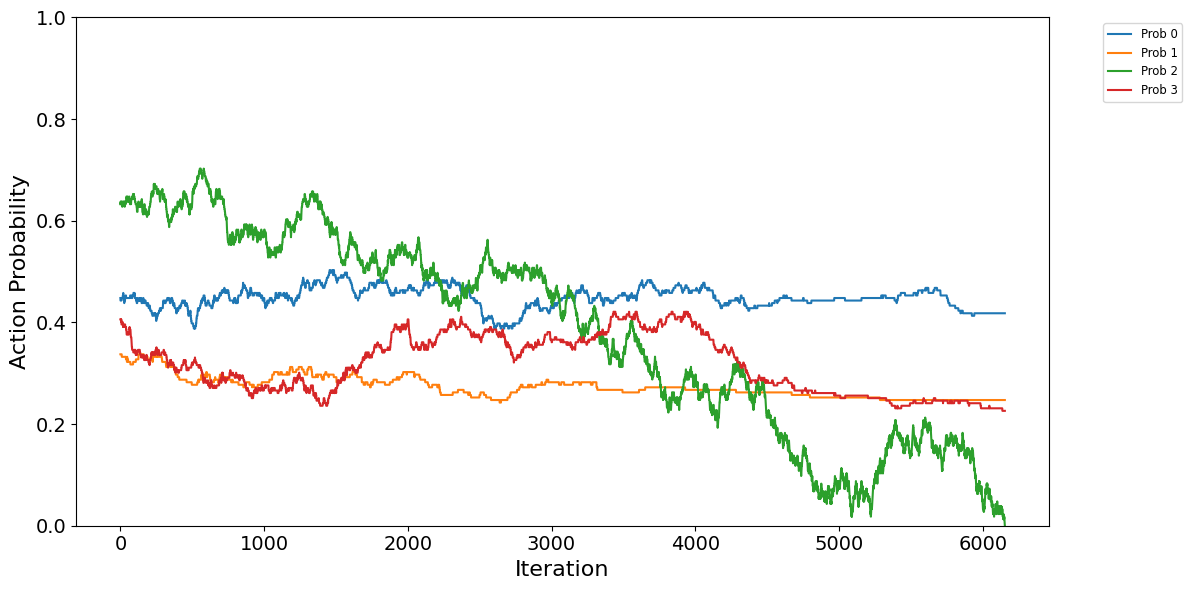

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm

# エージェントの基本クラス
class Agent:
    def __init__(self, initial_action):
        self.action = initial_action
        self.total_payoff = 0.0

    def update_payoff(self, payoff):
        self.total_payoff += payoff

# ZD戦略を持つエージェントクラス
class ZDAgent(Agent):
    def __init__(self, x0ov, x0und, W, kappa, chi):
        self.actions = {"x_ov": x0ov, "x_und": x0und}
        initial_action_key = np.random.choice(["x_ov", "x_und"])
        super().__init__(self.actions[initial_action_key])
        self.W = W
        self.kappa = kappa
        self.chi = chi
        self.current_action_key = initial_action_key

    def choose_action(self, B):
        T0 = self.calculate_probability(B)
        if np.random.random() <= T0:
            self.action = self.actions["x_und"]
            self.current_action_key = "x_und"
        else:
            self.action = self.actions["x_ov"]
            self.current_action_key = "x_ov"

    def calculate_probability(self, B):
        return B / self.W + 1.0 if self.current_action_key == "x_und" else B / self.W

# 通常のエージェントクラス
class NormalAgent(Agent):
    def __init__(self, a, b, c, N):
        self.actions = {
            "xc": (a - c) / (2 * N * b),
            "xn": (a - c) / ((N + 1) * b)
        }
        initial_action_key = "xc" if np.random.random() < 0.5 else "xn"
        super().__init__(self.actions[initial_action_key])
        self.a = a
        self.b = b
        self.c = c
        self.N = N
        self.current_action_key = initial_action_key
        self.qarray = np.random.rand(2*2*(N-1))

    def calc_payoff(self, qarray, agents, number, a, b, c):
        actions = []
        if qarray.all == self.qarray.all:
            for i, agent in enumerate(agents):
                actions.append(agent.action)
            xtot = sum(actions)
            # 利得を計算
            return ((a - b * xtot) * theta(a - b * xtot) - c) * actions[number]
        else:
            for i, agent in enumerate(agents):
                if i == number:
                    # 自分の仮定行動を `qarray` に基づいて計算
                    if np.random.random() < qarray[self.prev_action_index]:
                        actions.append(self.actions["xc"])
                    else:
                        actions.append(self.actions["xn"])
                else:
                    actions.append(agent.action)
            xtot = sum(actions)
            # 利得を計算
            return ((a - b * xtot) * theta(a - b * xtot) - c) * actions[number], actions[number]

    def choose_action(self, zd_action, other_actions, zd_actions, agents, number, a, b, c, t, N):
        self_discrete = 0 if self.action == self.actions["xc"] else 1
        other_count = sum(1 for action in other_actions if action == self.actions["xc"])
        self.prev_action_index = self_discrete *(N-1)*2 + other_count
        #print(self.prev_action_index)

        if t != 0:
            if np.random.random() < self.qarray[self.prev_action_index]:
                self.action = self.actions["xc"]
                self.current_action_key = "xc"
            else:
                self.action = self.actions["xn"]
                self.current_action_key = "xn"

        """ランダムにqarrayを変化させて期待利得を比較し、改善があれば採用する。"""
        # qarrayの変更を作成 (+0.001 または -0.001)
        delta = np.zeros_like(self.qarray)  # deltaの初期化
        delta[self.prev_action_index] = np.random.choice([-0.01, 0.01])  # 指定されたインデックスだけ変更
        new_qarray = np.clip(self.qarray + delta, 0.0, 1.0)  # [0, 1]の範囲に制限

        # 期待利得を計算
        current_payoff = self.calc_payoff(self.qarray, agents, number, a, b, c)
        new_payoff, new_action = self.calc_payoff(new_qarray, agents, number, a, b, c)

        # 改善があれば新しいqarrayを採用
        if new_payoff > current_payoff:
            self.qarray = new_qarray
            self.action = new_action
            return True
        return False
        
# ステップ関数
def theta(y):
    return 1.0 if y >= 0 else 0.0

# 各エージェントの利得を計算
def calculate_payoffs(agents, a, b, c):
    xtot = sum(agent.action for agent in agents)
    for agent in agents:
        payoff = ((a - b * xtot) * theta(a - b * xtot) - c) * agent.action
        agent.update_payoff(payoff)

# シミュレーション実行
def run_simulation(N, NTIME, a, b, c, xmax, chi, kappa):
    results_1 = []
    prob_history = []
    payoff_history = []
    action_counts = {"xc": 0, "xn": 0}
    agents = [NormalAgent(a, b, c, N) for _ in range(N)]  # ZDAgent を除外して NormalAgent のみに

    s = 0
    with open("simulation_results_normal_only.txt", "w") as file:
        file.write("TimeStep,Smj_avg,Actions,qarray\n")
        for t in tqdm(range(NTIME), desc="Simulation Progress"):
            previous_actions = [agent.action for agent in agents]
            improved = False

            for i in range(N):
                other_actions = [previous_actions[j] for j in range(N) if j != i]
                if agents[i].choose_action(None, other_actions, None, agents, i, a, b, c, t, N):
                    improved = True
                    qarray_str = ",".join(map(str, np.mean([agent.qarray for agent in agents], axis=0)))

            calculate_payoffs(agents, a, b, c)

            # アクションカウント
            for agent in agents:
                if agent.current_action_key == "xc":
                    action_counts["xc"] += 1
                elif agent.current_action_key == "xn":
                    action_counts["xn"] += 1

            Smj = np.mean([
                agent.action * ((a - b * sum(agent.action for agent in agents)) * theta(a - b * sum(agent.action for agent in agents)) - c)
                for agent in agents
            ])
            results_1.append(Smj)

            if improved:
                s += 1
                current_payoffs = [agent.action * ((a - b * sum(agent.action for agent in agents)) * theta(a - b * sum(agent.action for agent in agents)) - c) for agent in agents]
                payoff_history.append(current_payoffs)
                prob_history.append(np.mean([agent.qarray for agent in agents], axis=0))
                actions_str = ",".join(map(str, [agent.action for agent in agents]))
                file.write(f"{t},{Smj},{actions_str},{qarray_str}\n")

    # 最後に NumPy 配列へ変換（NTIME × N の形になる）
    payoff_history = np.array(payoff_history)

    # payoff_history（生データ）をファイル保存
    np.savetxt("payoff_history_normal.txt", payoff_history, fmt="%.6f", delimiter=",")

    # アクションカウントをメモに保存
    with open("action_counts_summary_normal_only.txt", "w") as memo_file:
        memo_file.write("Action Counts Summary:\n")
        memo_file.write(f"xc: {action_counts['xc']}\n")
        memo_file.write(f"xn: {action_counts['xn']}\n")

    return results_1, np.array(prob_history), payoff_history, t+1


if __name__ == "__main__":
    N = 2  # エージェント数
    NTIME = 100000000 # タイムステップ数
    a, b, c, xmax = 2.0, 1.0, 1.0, 2.5
    chi, kappa = 1.0, 0.0

    results, prob_history, payoff_history, s = run_simulation(N, NTIME, a, b, c, xmax, chi, kappa)
    